# Versuch 4
## Mit VGGFace

In [17]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D, Flatten, Dropout, Input
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import ResNet50

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.utils import preprocess_input

TRAIN_DIR = "./persons-cropped/"
TEST_DIR = "./persons-cropped-test/"
BATCH_SIZE = 10
TEST_BATCH_SIZE = 12
HEIGHT = 224
WIDTH = 224

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=45,
      horizontal_flip=False,
      vertical_flip=False
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   color_mode='rgb')

validation_generator = train_datagen.flow_from_directory(TEST_DIR,
                                                        target_size=(HEIGHT,WIDTH),
                                                        batch_size=TEST_BATCH_SIZE,
                                                        class_mode='categorical',
                                                        color_mode='rgb')

Found 3800 images belonging to 140 classes.
Found 708 images belonging to 140 classes.


#### Model:

In [27]:
from keras_vggface.vggface import VGGFace
x=Dropout(0.2, input_shape=(224,224,3))
base_model = VGGFace(include_top=False, input_shape=(224, 224, 3), weights='vggface')
#base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(HEIGHT,WIDTH,3)) #imports the mobilenet model and discards the last 1000 neuron layer.
#base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
#x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x=Dense(1024,activation='relu')(x) #dense layer 2
#x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(140,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture


model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [29]:
from keras.callbacks import ModelCheckpoint
model.compile(optimizer=Adam(lr= 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
num_test_images = 708

filepath="./checkpoints/" + "VGGFace" + "_model_weights_verbose.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["val_acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=20,
                    validation_data=validation_generator,
                   validation_steps=12,
                   callbacks=callbacks_list,
                   verbose=1)

Epoch 1/20
10/10 [==============================] - 35s 4s/step - loss: 38.1084 - accuracy: 0.0000e+00 - val_loss: 40.8487 - val_accuracy: 0.0069

Epoch 00001: saving model to ./checkpoints/VGGFace_model_weights_verbose.h5
Epoch 2/20
 2/10 [=====>........................] - ETA: 11s - loss: 35.7152 - accuracy: 0.1000

KeyboardInterrupt: 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


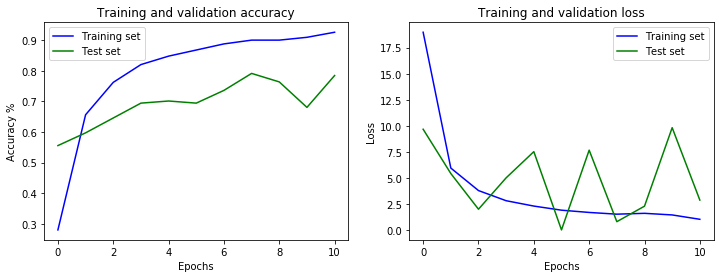

In [8]:
def plot_training(history):
    print(history.history.keys())
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    ax0 = axes[0]
    ax1 = axes[1]

    ax0.plot(epochs, acc, 'b')
    ax0.plot(epochs, val_acc, 'g')
    ax0.legend(['Training set','Test set'])
    ax0.title.set_text('Training and validation accuracy')
    ax0.set_xlabel('Epochs')
    ax0.set_ylabel('Accuracy %')
    
    ax1.plot(epochs, loss, 'b')
    ax1.plot(epochs, val_loss, 'g')
    ax1.legend(['Training set','Test set'])
    ax1.title.set_text('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    plt.savefig('acc_vs_epochs_Adam_e4.png')
    plt.show()
    
plot_training(model.history)